## Complex Faulted Model with `curlew`

This notebooks walks you through the generation, sampling and subsequent interpolation of a model with a stratigraphic sequence intruded by a dyke, followed by a sequence of listric faults, with an additional unconformity between the faulting events.

In [ ]:
import curlew
import numpy as np
import matplotlib.pyplot as plt
from curlew import HSet
from curlew.geometry import grid
from curlew.fields.analytical import ALF, AEF, ACF
from curlew.visualise import plot2D, plotConstraints, showModel
from curlew.geology import strati, fault, domainBoundary, sheet
from curlew.geology.model import GeoModel
from curlew.data import sample
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Import the necessary libraries
import curlew
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cm
import cmasher as cmr
import torch
import random

# Change this to "cuda" if you have CUDA cores
curlew.device = 'cpu'
curlew.dtype = torch.float64

In [ ]:
# Plotting params (For an even prettier look!)
from matplotlib import colors
import matplotlib as mpl
import matplotlib.font_manager as font_manager

font_dirs = ['../Utils/',]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs[0], fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
# Plotting params
# RCParams
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams["mathtext.fontset"] = "stixsans"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

# Curlew colormap
import matplotlib.colors as mcolors

# Define the colors extracted manually from the provided logo image
colors = [
    "#A6340B",  # rich red (not darkest)
    "#E35B0E",  # vibrant orange-red
    "#F39C12",  # medium orange
    "#F0C419",  # bright orange-yellow
    "#FAE8B6",  # soft pale orange (close to white but not pure white)
    "#8CD9E0",  # light cyan blue
    "#31B4C2",  # medium cyan-blue
    "#1B768F",  # medium blue 
    "#054862",  # deeper blue (not darkest)
]

# Create a discrete colormap using these colors
curlew_cmap = mcolors.ListedColormap(colors)
curlew_cont = mcolors.LinearSegmentedColormap.from_list(name="curlew_cont", colors=colors)

# Random seed
random.seed(42)

In [ ]:
# curlew.geometry allows us to define grids for model evaluation
from curlew.geometry import grid

# Let us define a domain and a grid within the domain
dims = (1500,700)
grid_obj = grid(dims, step=(1, 1), center=(dims[0]/2, dims[1]/2))
gxy = grid_obj.coords()
grid_obj.sampleArgs = dict(N=1024)

# We also define seed points for defining isosurfaces (contacts)
nlayers = 6
sy = np.linspace(0, dims[1], nlayers)
sy2 = np.linspace(350, dims[1], nlayers)
sx = [dims[0]/10 for s in sy]
sx2 = [9*dims[0]/10 for s in sy]
sxy = np.array([sx,sy]).T
sxy2 = np.array([sx2,sy2]).T

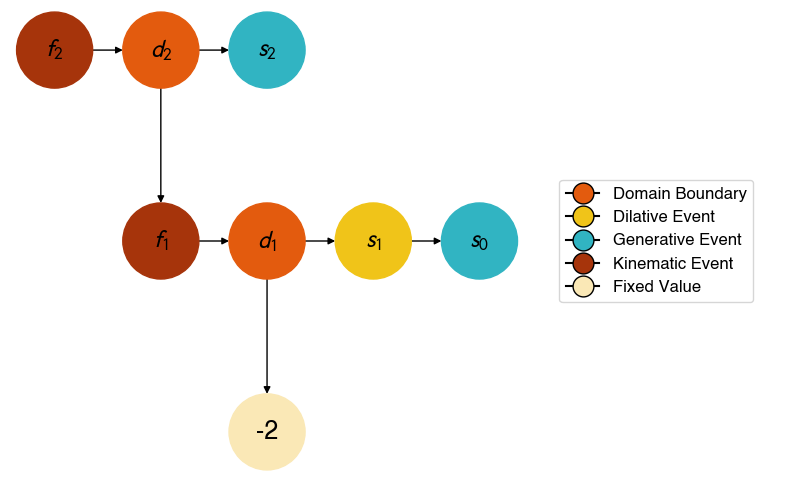

In [4]:
# Build a synthetic model
s0 = strati('s0', C=ALF('f0', input_dim=2)) # bassin fill
# Define units (isosurfaces) in this field
for i,s in enumerate(sxy):
    s0.addIsosurface("S%d"%(i+1), seed=s)

s1 = sheet( 's1',
           C=ALF( 'f1', input_dim=2, origin=np.array([750,300]), gradient=np.array([-0.5,0.5]) ), 
           aperture=2, contact=(-20,20) ) # dyke

intrusion = -2 # intrusion
d1 = domainBoundary( 'd1', 
           C=ACF( 'f2', input_dim=2, origin=np.array([400,50]), gradient=np.array([0.4,1.]), curve=(0,0.002) ),
            bound=0, lt=[intrusion], gt=[s0, s1] ) # domain boundary 1
f1 = fault( 'f1', 
           C=AEF( 'f3', input_dim=2, origin=np.array([650,700]), fault_ceil=700., fault_floor=0., curvature_rate=0.006),
           offset=100, highcurve=True, sigma1=[1, -1]) # listric fault 1
s2 = strati('s2', C=ALF( 'f4', input_dim=2, 
                         origin=np.array([0,500]),
                         gradient=np.array([0.0,1.0]) ) ) # unconformity surface
# Define units (isosurfaces) in this field
for i,s in enumerate(sxy2):
    s2.addIsosurface("S%d"%(i+1), seed=s)

d2 = domainBoundary( 'd2', 
           C=ALF( 'f5', input_dim=2, origin=np.array([700,500]), gradient=np.array([0.2,0.9]) ),
            bound=0, lt=[d1,f1], gt=[s2] ) # domain boundary 2
f2 = fault( 'f2', 
           C=AEF( 'f6', input_dim=2, origin=np.array([350,700]), fault_ceil=700., fault_floor=0., curvature_rate=0.006),
           offset=100, highcurve=True, sigma1=[1, -1]) # listric fault 2

analytical_M = GeoModel([d2, f2])
# Plot the model tree
showModel(analytical_M, title=None)

In [5]:
# Let us sample the model to acquire constraints.
from curlew.data import sample

Cg = sample(gxy, analytical_M.predict(gxy), dims, breaks=6, xstep=550)

C0 = Cg[4] # basin fill
C1 = sample(gxy, s1.predict(gxy), dims, breaks=[-20, 20], xstep=220, pval=1) # dyke
C2 = sample(gxy, d1.predict(gxy), dims, breaks=[0], pval=1) # domaim boundary 1
C3 = sample(gxy, f1.predict(gxy), dims, breaks=[0], xstep=300, pval=1) # fault
C4 = Cg[2] # strati
C5 = sample(gxy, d2.predict(gxy), dims, breaks=[0], xstep=500, pval=1) # domaim boundary 2
C6 = sample(gxy, f2.predict(gxy), dims, breaks=[0], xstep=300, pval=1) # fault 2

C = [C0, C1[0], C2[0], C3[0], C4, C5[0], C6[0]]

# Filter out constraints
# For dyke
keep_dyke = np.logical_and(C[1].gp[:, 0] > 400, C[1].gp[:, 0] < 1000)
C[1].gp = C[1].gp[keep_dyke]
C[1].gv = C[1].gv[keep_dyke]
C[1].vp = C[1].vp[keep_dyke]
C[1].vv = C[1].vv[keep_dyke]

C[2].vv = C[2].vv * 0 # ensure value constraints are exactly zero for domain boundaries (bound = 0)
C[5].vv = C[5].vv * 0 

C[3].vv = C[3].vv * 0 # ensure value constraints are exactly zero for faults (bound = 0)
C[6].vv = C[6].vv * 0

# Remove the tilted constraint from stratigraphy
C[0].vp = C[0].vp[:-1]
C[0].vv = C[0].vv[:-1]
C[0].gp = np.vstack([C[0].gp[:7], C[0].gp[8:]])
C[0].gv = np.vstack([C[0].gv[:7], C[0].gv[8:]])

In [6]:
# Dyke upper
idx_upper = C[1].vv > 0.
idx_lower = C[1].vv < 0.
# Add isosurfaces
for i, k in enumerate([idx_lower, idx_upper]):
    s1.addIsosurface(name=str(i), seed=C[1].vp[k])

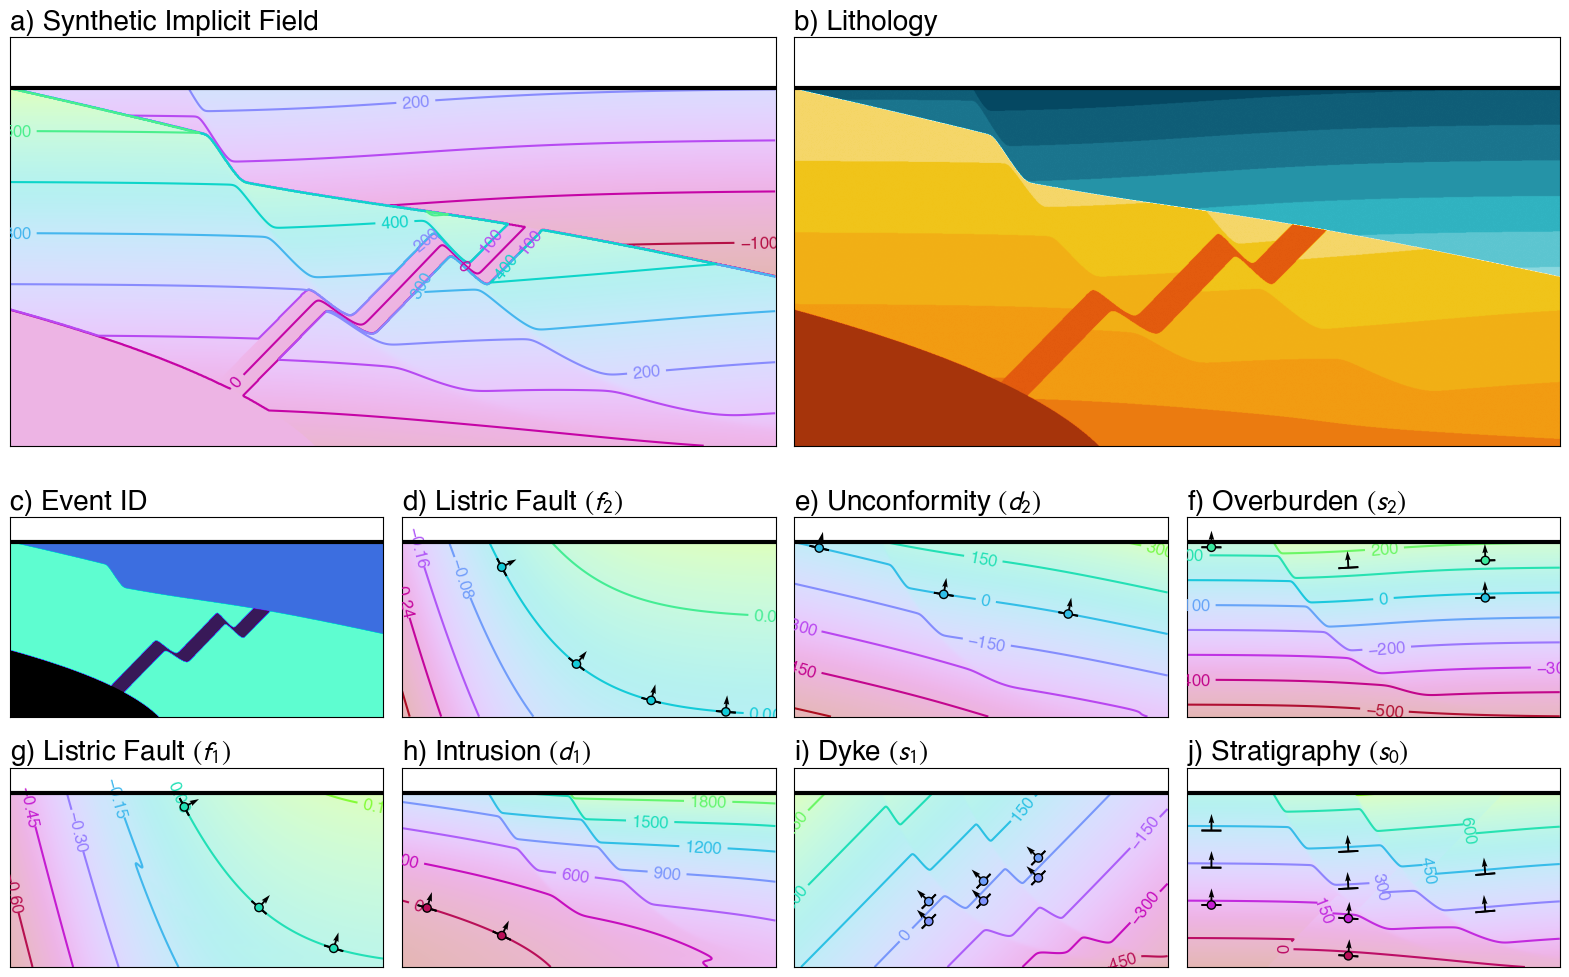

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create the figure
fig = plt.figure(figsize=(20, 13))  # adjust as needed
labels_ = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) "]
names_ = [r"Synthetic Implicit Field", r"Lithology", r"Event ID",
          r"Listric Fault $\left( f_2 \right)$", r"Unconformity $\left( d_2 \right)$", r"Overburden $\left( s_2 \right)$",
          r"Listric Fault $\left( f_1 \right)$", r"Intrusion $\left( d_1 \right)$", r"Dyke $\left( s_1 \right)$",
          r"Stratigraphy $\left( s_0 \right)$"]
# plt.tight_layout()

# Set up the grid with 3 rows and 4 columns (flexible)
gs = gridspec.GridSpec(3, 4, height_ratios=[2, 1, 1], hspace=0.001, wspace=0.05)

# === Row 1: Two big figures ===
ax1 = fig.add_subplot(gs[0, :2])  # First two columns
ax2 = fig.add_subplot(gs[0, 2:])  # Last two columns

# === Row 2: Four small figures ===
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[1, 3])

# === Row 3: Three small centered figures ===
# To center them, leave column 0 and 3 empty
ax7 = fig.add_subplot(gs[2, 0])
ax8 = fig.add_subplot(gs[2, 1])
ax9 = fig.add_subplot(gs[2, 2])
ax10 = fig.add_subplot(gs[2, 3])

axs_ = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
_ = [a.set_xticks([]) for a in axs_]
_ = [a.set_yticks([]) for a in axs_]
_ = [a.set_ylim([0, dims[1]+100]) for a in axs_]
_ = [a.set_xlim([0, dims[0]]) for a in axs_]
_ = [a.axhline(700, c="k", lw=3, zorder=9) for a in axs_]

# Predict
pred = analytical_M.predict(gxy)
cid, labels = analytical_M.classify(gxy, return_vals=False)
cid[cid[:, 1] == 6, 0] = 0
cid[cid[:, 1] == 6, 1] = 0
# classes = np.hstack([ h['classID'] for h in holes ]) # limit to classes in drillholes
vmn=np.min(cid)
vmx=np.max(cid)

# To plot
to_plot = [pred[:, 0], cid[:, 0], cid[:, 1]]

# OPTIONAL: Turn off axes or add sample content
for i, ax in enumerate(axs_):
    if i < 3:
        if i == 0:
            plot2D(to_plot[i], grid_obj, ax=ax, cmap=cmr.neon)
        elif i == 1:
            plot2D(to_plot[i], grid_obj, ax=ax, cmap=curlew_cont, levels=False, alpha=1)
        else:
            plot2D(to_plot[i], grid_obj, ax=ax, cmap=cmr.cosmic, levels=False, alpha=1)
    else:
        current_plot = analytical_M.fields[::-1][i - 3].predict(gxy)[:, 0]
        vmn=np.min(current_plot)
        vmx=np.max(current_plot)
        plot2D(current_plot, grid_obj, ax=ax, cmap=cmr.neon)
        plotConstraints(ax, C[::-1][i - 3], ll=1.2, lw=0.005, scale=0.015,
                        ac="k", vmn=vmn, vmx=vmx, cmap=cmr.neon)
    ax.set_title(labels_[i] + names_[i], loc="left")

plt.savefig("./Figures/Listric_Faults_Model.png", dpi=350)
plt.show()

In [8]:
# define a random grid of control points to evaluate "global" losses
# (this random grid will be sampled during each epoch!)
for _C in C:
    _C.grid = grid_obj # specify (NGridPoints, [(xmn,xmx), (ymn,ymx)])
    _C.delta = 50 # numerical differentiation step used (in each axis)

params = dict(
    input_dim=2, # field input coordinate dimensions
    hidden_layers=[8,], # hidden layers
    rff_features=32, # number of fourier features
    length_scales=[2000]
)

H = HSet( value_loss=1, grad_loss='10', mono_loss=0, thick_loss=0)

s0 = strati('s0', C=C[0], 
            H=H.copy(value_loss="0.1", mono_loss="0.1"),
            **params) # bassin fill
# Define units (isosurfaces) in this field
for i,s in enumerate(sxy):
    s0.addIsosurface("S%d"%(i+1), seed=s)
    
s1 = sheet( 's1',
           C=C[1],
           H=H.copy(thick_loss="10"), 
           aperture=2, contact=(-20,20),
           **params ) # dyke
# Add isosurfaces
for i, k in enumerate([idx_lower, idx_upper]):
    s1.addIsosurface(name=str(i), seed=C1[0].vp[k])

intrusion = -2 # intrusion
d1 = domainBoundary( 'd1', 
            C=C[2],
            H=H.copy(value_loss=5, thick_loss="2"),
            bound=0, lt=[intrusion], gt=[s0,s1],
            **params ) # domain boundary 1
f1 = fault( 'f1', 
           C=C[3],
           H=H.copy(thick_loss="10"),
           offset=100, sigma1=[1, -1]/np.sqrt(2),
           **params ) # listric fault 1
s2 = strati('s2', 
            C=C[4],
            H=H.copy(value_loss="0.1", mono_loss="0.1"),
            **params ) # unconformity surface
# Define units (isosurfaces) in this field
for i,s in enumerate(sxy2):
    s2.addIsosurface("S%d"%(i+1), seed=s)

d2 = domainBoundary( 'd2', 
           C=C[5],
           H=H.copy(value_loss=5, thick_loss="2"),
           bound=0, lt=[d1,f1], gt=[s2],
            **params ) # domain boundary 2

f2 = fault( 'f2', 
           C=C[6],
           H=H.copy(thick_loss="10"),
           offset=100, sigma1=[1, -1]/np.sqrt(2),
            **params ) # listric fault 2

In [9]:
# combine into a geomodel
Model = GeoModel([d2, f2])

# fit scalar fields independently
loss = Model.prefit( epochs=1000, early_stop=None )

f2: 1000/1000|, value_loss=0.00912, grad_loss=0.251, thick_loss=0.2 
Evaluating: 100%|██████████| 105/105 [00:00<00:00, 141.66it/s]
d2: 1000/1000|, value_loss=0.00649, grad_loss=0.00713, thick_loss=0.00143
Evaluating: 100%|██████████| 105/105 [00:00<00:00, 131.08it/s]
s2: 1000/1000|, value_loss=0.0401, grad_loss=0.000256, mono_loss=0.000844
Evaluating: 100%|██████████| 105/105 [00:00<00:00, 129.39it/s]
f1: 1000/1000|, value_loss=0.00716, grad_loss=0.0323, thick_loss=0.0335
Evaluating: 100%|██████████| 105/105 [00:01<00:00, 54.94it/s]
d1: 1000/1000|, value_loss=0.00212, grad_loss=2.06e-5, thick_loss=0.00248
Evaluating: 100%|██████████| 105/105 [00:02<00:00, 48.09it/s]
s1: 1000/1000|, value_loss=1.01, grad_loss=0.00249, thick_loss=2.11
Evaluating: 100%|██████████| 105/105 [00:02<00:00, 37.58it/s]
s0: 1000/1000|, value_loss=0.0402, grad_loss=0.03, mono_loss=0.00239  


In [10]:
# Predict
pred = Model.predict(gxy)
cid, labels = Model.classify(gxy, return_vals=False)
cid[cid[:, 1] == 6, 0] = 0
cid[cid[:, 1] == 6, 1] = 0
# classes = np.hstack([ h['classID'] for h in holes ]) # limit to classes in drillholes
vmn=np.min(cid[:, 0])
vmx=np.max(cid[:, 0])
to_plot = [pred[:, 0], cid[:, 0], cid[:, 1]]

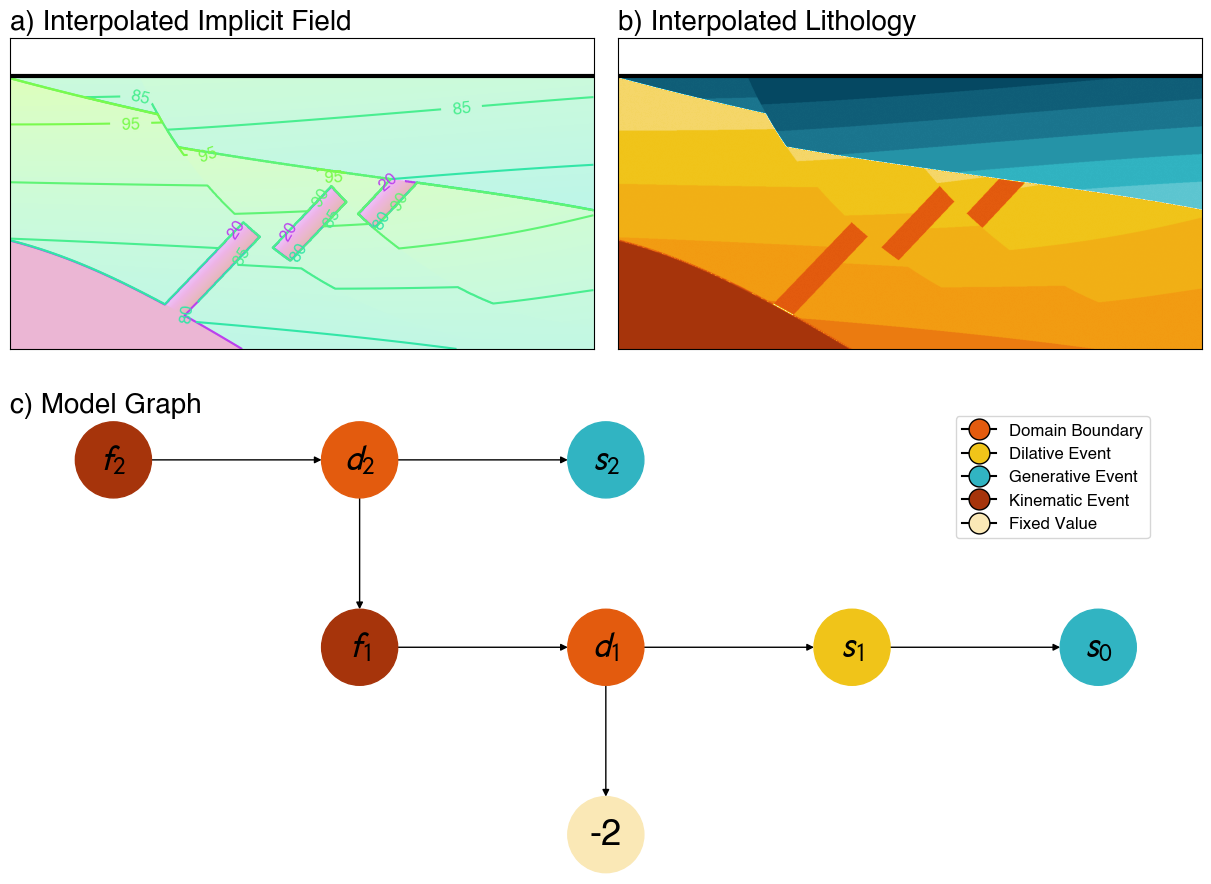

In [11]:
fig, axs = plt.subplot_mosaic([['upper left', 'upper right'],['lower', 'lower']], figsize=(12, 10), layout="compressed", height_ratios=[1, 1.2])

plot2D(to_plot[0], grid_obj, ax=axs["upper left"], cmap=cmr.neon, levels=[-20, 20, 80, 85, 90, 95])
axs["upper left"].set_title("a) Interpolated Implicit Field", loc="left")
plot2D(to_plot[1], grid_obj, ax=axs["upper right"], cmap=curlew_cont, levels=False, alpha=1)
axs["upper right"].set_title("b) Interpolated Lithology", loc="left")
showModel(Model, axs=axs["lower"], leg_loc=[0.75, 0.75, 0.25, 0.25], title="c) Model Graph", node_size=3000, font_size=26)

_ = [a[1].set_xticks([]) for a in list(axs.items())[:-1]]
_ = [a[1].set_yticks([]) for a in list(axs.items())[:-1]]
_ = [a[1].set_ylim([0, dims[1]+100]) for a in list(axs.items())[:-1]]
_ = [a[1].set_xlim([0, dims[0]]) for a in list(axs.items())[:-1]]
_ = [a[1].axhline(700, c="k", lw=3, zorder=9) for a in list(axs.items())[:-1]]

plt.savefig("./Figures/Interpolated_Listric.png", dpi=350)
plt.show()